In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', None)

# 正解率の分析

### accuracyの分析

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
# 参加者の数を確認
num_participants = df['participant_id'].nunique()
print(f'被験者数: {num_participants}')

# 被験者×scale ごとに 縞模様なしaccuracy を チェックし 不正解のペアを除外する
baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['accuracy'].mean().reset_index(name='no_stripe_acc_mean')

bad = baseline[baseline['no_stripe_acc_mean'] < 1]

if not bad.empty:
    bad_pairs = set(zip(bad['participant_id'], bad['scale']))
    print(f"縞模様なしで読めなかった被験者×scale ペア:{bad_pairs}\n")
    mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
    df = df[~mask].reset_index(drop=True)


sf_values = sorted(df['scale'].unique())
angle_values = sorted(df['angle'].unique())

# 集計: type, scale_factor, duty_cycle, line_period, line_angle ごとのサマリ
summary = df.groupby(['scale','line_width','period','angle']).agg(
    n=('accuracy','size'),
    mean_acc=('accuracy','mean'),
).reset_index()

# 角度ごとに line_period × line_width の平均精度を計算してヒートマップを描画
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    scale_order = ["intended", "50cm", "75cm", "100cm"]
    print(f"---{angle}°---")
    for scale in scale_order:
        sub_scale = sub[sub['scale'] == scale]

        # グルーピングして平均
        pivot = sub_scale.groupby(['period', 'line_width'])['accuracy'].mean().unstack()
        
        #line_width == 0 のときは精度だけ出力して終了
        if 0 in pivot.columns:
            base_period = pivot.index.min()
            no_stripe_acc = pivot.loc[base_period, 0]
            print(f'scale={scale} -> no_stripe_accuracy: {no_stripe_acc:.2f}')
            continue
        
        

        #軸を固定
        x_index = list(range(1, 8))
        y_index = list(range(2, 9))
        pivot = pivot.reindex(index=y_index, columns=x_index)

        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'accuracy (0-1)'})
        plt.title(f'accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        plt.show()


精度　折れ線グラフ

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダ確認
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"注意: フォルダ '{data_folder}' が見つからなかったため作成しました。")

# CSVファイル取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# CSV読み込み
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"ファイル {file_name} の読み込みに失敗しました: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    print(f"被験者数: {df['participant_id'].nunique()}")

    # 不正解ペアの除外処理
    if 0 in df['line_width'].unique():
        baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['accuracy'].mean().reset_index(name='no_stripe_acc_mean')
        bad = baseline[baseline['no_stripe_acc_mean'] < 1]
        if not bad.empty:
            bad_pairs = set(zip(bad['participant_id'], bad['scale']))
            mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
            df = df[~mask].reset_index(drop=True)

    # ---------------------------------------------------------
    # 解析パラメータ設定
    # ---------------------------------------------------------
    ANGLE = [90.0]
    LINE_WIDTH = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    PERIOD = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # フィルタリング
    target_df = df[
        (df['angle'].isin(ANGLE)) &
        (df['line_width'].isin(LINE_WIDTH)) &
        (df['period'].isin(PERIOD))
    ].copy()

    # 距離変換
    scale_to_distance_map = {
        "100cm": 100,
        "75cm": 75,
        "50cm": 50,
        "36cm": 36.8
    }
    target_df['distance'] = target_df['scale'].map(scale_to_distance_map)
    target_df = target_df.dropna(subset=['distance'])

    if target_df.empty:
        print("条件に一致するデータがありませんでした。")
    else:
        # ---------------------------------------------------------
        # データ名の変更
        # ---------------------------------------------------------
        target_df = target_df.rename(columns={
            'line_width': 'line',
            'period': 'pitch'
        })

        # 凡例を整数にするために int型へ変換
        target_df['line'] = target_df['line'].astype(int)
        target_df['pitch'] = target_df['pitch'].astype(int)

        # ---------------------------------------------------------
        # プロット
        # ---------------------------------------------------------
        plot_mean_df = (
            target_df
            .groupby(['distance', 'line', 'pitch'], as_index=False)
            .agg(
                accuracy_mean=('accuracy', 'mean'),
                accuracy_std=('accuracy', 'std'),
                n=('accuracy', 'count')
            )
        )

        display(plot_mean_df)

    
        plt.figure(figsize=(10, 6))

        sns.lineplot(
            data=target_df,
            x='distance',
            y='accuracy',
            hue='line',
            style='pitch',
            palette='viridis',
            markers=True,
            markersize=10,
            dashes=False,
            errorbar=None,
        )

        #plt.title('Accuracy vs Distance')
        plt.xlabel('Distance (cm)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim(-0.00, 1.00)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        legend = plt.legend(
            fontsize=10,
            bbox_to_anchor=(1.01, 1),
            loc='upper left',
            borderaxespad=0.
        )

        # ===== ここが重要 =====
        # 凡例テキストを直接書き換える
        for text in legend.get_texts():
            if text.get_text() == 'line':
                text.set_text('Line (px)')
            elif text.get_text() == 'pitch':
                text.set_text('Pitch (px)')

        plt.tight_layout()
        plt.show()

頑強条件のグラフ

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)

# 集計: scale, line_width, line_period, line_angle, duty ごとのサマリ
summary = df.groupby(['scale','line_width','period','angle','accuracy']).agg(
    n=('accuracy','size'),
    mean_acc=('accuracy','mean'),
).reset_index()

filtered = summary[(summary['line_width'] == 2) & (summary['period'] == 8)].copy()

scale_to_distance = {
    "100cm": 100,
    "75cm": 75,
    "50cm": 50,
    "intended": 36.8
}


# データが空の場合は処理を中断
if df.empty:
    print("データが見つかりませんでした。CSVファイルを確認してください。")
else:
    # 前処理：scale列の 'intended' を '36cm' に置換して扱いやすくする
    df['scale'] = df['scale'].replace({'intended': '36cm'})

    # 参加者の数を確認
    num_participants = df['participant_id'].nunique()
    print(f'被験者数: {num_participants}')

    # ---------------------------------------------------------
    # 不正解ペアの除外処理
    # ---------------------------------------------------------
    baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['accuracy'].mean().reset_index(name='no_stripe_acc_mean')
    bad = baseline[baseline['no_stripe_acc_mean'] < 1]

    if not bad.empty:
        bad_pairs = set(zip(bad['participant_id'], bad['scale']))
        print(f"縞模様なしで読めなかった被験者×scale ペア:{bad_pairs}\n")
        mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
        df = df[~mask].reset_index(drop=True)

    # ---------------------------------------------------------
    # 1. 設定：抽出条件
    # ---------------------------------------------------------
    THRESHOLD_ACC_36CM_MIN = 0.9
    THRESHOLD_ACC_MAX = 0.7
    THRESHOLD_DISTANCE = '75cm'

    # ---------------------------------------------------------
    # パラメータ探索関数
    # ---------------------------------------------------------
    def find_best_parameters(df):
        grouped = df.groupby(['angle', 'line_width', 'period', 'scale'])['accuracy'].mean().reset_index()
        pivot_df = grouped.pivot_table(
            index=['angle', 'line_width', 'period'], 
            columns='scale', 
            values='accuracy'
        ).reset_index()
        pivot_df.columns.name = None

        if '36cm' not in pivot_df.columns or THRESHOLD_DISTANCE not in pivot_df.columns:
            return pd.DataFrame()

        condition = (
            (pivot_df['36cm'] >= THRESHOLD_ACC_36CM_MIN) & 
            (pivot_df[THRESHOLD_DISTANCE] < THRESHOLD_ACC_MAX)
        )
        result_df = pivot_df[condition].copy()
        result_df = result_df.sort_values(by=[THRESHOLD_DISTANCE, '36cm'], ascending=[True, False])

        return result_df

    best_params = find_best_parameters(df)

    print(f"--- 抽出条件 ---")
    print(f"36cm 正解率 > {THRESHOLD_ACC_36CM_MIN}")
    print(f"{THRESHOLD_DISTANCE} 正解率 < {THRESHOLD_ACC_MAX}")
    print(f"該当件数: {len(best_params)} 件\n")

    if not best_params.empty:
        cols = ['angle', 'line_width', 'period', '36cm', '50cm', '75cm', '100cm']
        available_cols = [c for c in cols if c in best_params.columns]
        
        print("--- 推奨パラメータ候補 ---")
        print(best_params[available_cols].to_string(index=False))
        
        # ---------------------------------------------------------
        # グラフ描画機能 (距離を数値として扱う版)
        # ---------------------------------------------------------
        print("\n--- グラフを作成中 ---")
        plt.figure(figsize=(10, 6))

        # 文字列のラベルと実際の数値のマッピング
        # データに含まれているカラムのみを使用するための準備
        dist_map = {'36cm': 36, '50cm': 50, '75cm': 75, '100cm': 100}
        
        # データフレームに存在するカラムだけを抽出してソート
        existing_cols = [c for c in ['36cm', '50cm', '75cm', '100cm'] if c in df['scale'].unique()]
        
        # X軸用の数値リストを作成 (例: [36, 50, 75, 100])
        x_nums = [dist_map[c] for c in existing_cols]
        
        # 追加機能：抽出条件（閾値）の可視化
        # 36cmの条件 
        if '36cm' in dist_map:
            x_36 = dist_map['36cm']
            # 赤い横線マーカーで閾値を示す
            plt.plot(x_36, THRESHOLD_ACC_36CM_MIN, marker='_', markersize=20, markeredgewidth=3, color='red', zorder=10)
            plt.text(x_36, THRESHOLD_ACC_36CM_MIN - 0.03, f'Min {THRESHOLD_ACC_36CM_MIN}', 
                     color='red', ha='center', va='top', fontweight='bold', fontsize=10)

        # 指定距離の条件 
        if THRESHOLD_DISTANCE in dist_map:
            x_target = dist_map[THRESHOLD_DISTANCE]
            # 赤い横線マーカーで閾値を示す
            plt.plot(x_target, THRESHOLD_ACC_MAX, marker='_', markersize=20, markeredgewidth=3, color='red', zorder=10)
            plt.text(x_target, THRESHOLD_ACC_MAX + 0.03, f'Max {THRESHOLD_ACC_MAX}', 
                     color='red', ha='center', va='bottom', fontweight='bold', fontsize=10)

        # 2. 推奨パラメータをプロット
        colors = plt.cm.tab10(range(len(best_params)))

        for i, (idx, row) in enumerate(best_params.iterrows()):
            label = f"P{int(row['period'])}_L{int(row['line_width'])}_A{int(row['angle'])}"
            y_vals = [row.get(c, float('nan')) for c in existing_cols]
            
            color = colors[i % len(colors)]
            # 横軸に数値(x_nums)を指定してプロット
            plt.plot(x_nums, y_vals, label=label, marker='o', color=color)


        # グラフの装飾
        plt.title('Accuracy by Distance')
        plt.xlabel('Distance (cm)')
        plt.ylabel('Accuracy')
        plt.ylim(0.00, 1.00)
        
        # X軸のメモリ設定：データの位置に合わせてラベルを表示し、範囲を調整
        plt.xticks(x_nums, existing_cols) # メモリの位置は数値、ラベルは'36cm'等の文字
        plt.xlim(20, 110) # 0cmから110cmまで表示して距離感をわかりやすくする

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()

        plt.show()

    else:
        print("条件を満たすパラメータは見つかりませんでした。条件を緩めて再試行してください。")

### TorFの分析

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
# 参加者の数を確認
num_participants = df['participant_id'].nunique()
print(f'被験者数: {num_participants}')

# 被験者×scale ごとに 縞模様なしaccuracy を チェックし 不正解のペアを除外する
baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['accuracy'].mean().reset_index(name='no_stripe_acc_mean')

bad = baseline[baseline['no_stripe_acc_mean'] < 1]

if not bad.empty:
    bad_pairs = set(zip(bad['participant_id'], bad['scale']))
    print(f"縞模様なしで読めなかった被験者×scale ペア:{bad_pairs}\n")
    mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
    df = df[~mask].reset_index(drop=True)


# データ前処理
# 'T'を1(正解)、'F'を0(不正解)に変換します。
df['correct_flag'] = df['TorF'].map({'T': 1, 'F': 0})

scale_order = ["intended", "50cm", "75cm", "100cm"]

# 角度ごとにループ
for angle in sorted(df['angle'].unique()):
    sub = df[df['angle'] == angle]
    print(f"---{angle}°---")
    for scale in scale_order:
        # 該当スケールのデータがない場合はスキップ
        if scale not in sub['scale'].values:
            continue
            
        sub_scale = sub[sub['scale'] == scale]

        # グルーピングして「正解した割合（correct_flagの平均）」を算出
        # Z軸 = correct_flag の mean
        pivot = sub_scale.groupby(['period', 'line_width'])['correct_flag'].mean().unstack()
        
        # line_width == 0 (縞模様なし) の扱い
        if 0 in pivot.columns:
            # 最も小さい period 行から取る（0行が無い可能性を考慮）
            base_period = pivot.index.min()
            no_stripe_acc = pivot.loc[base_period, 0]
            print(f'scale={scale}, angle={angle}° -> no_stripe_accuracy (TorF based): {no_stripe_acc:.2f}')
            continue

        # 軸を固定 (元コードの設定を維持)
        x_index = list(range(1, 8)) # line_width
        y_index = list(range(2, 9)) # period
        
        # 指定したインデックス・カラムで再構築（存在しない箇所はNaNまたは空欄になります）
        pivot = pivot.reindex(index=y_index, columns=x_index)

        # ヒートマップ描画
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1,
                    cbar_kws={'label': 'Accuracy Rate (TorF based)'})
        
        plt.title(f'Accuracy (scale={scale}, angle={angle}°)')
        plt.xlabel('Line width')
        plt.ylabel('Line period')
        plt.tight_layout()
        #plt.show()

TF 折れ線グラフ

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダ確認
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"注意: フォルダ '{data_folder}' が見つからなかったため作成しました。")

# CSVファイル取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# CSV読み込み
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"ファイル {file_name} の読み込みに失敗しました: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    print(f"被験者数: {df['participant_id'].nunique()}")

    # 不正解ペアの除外処理
    if 0 in df['line_width'].unique():
        baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['accuracy'].mean().reset_index(name='no_stripe_acc_mean')
        bad = baseline[baseline['no_stripe_acc_mean'] < 1]
        if not bad.empty:
            bad_pairs = set(zip(bad['participant_id'], bad['scale']))
            mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
            df = df[~mask].reset_index(drop=True)
            
    # 'T'を1(正解)、'F'を0(不正解)に変換します。
    df['correct_flag'] = df['TorF'].map({'T': 1, 'F': 0})

    # ---------------------------------------------------------
    # 解析パラメータ設定
    # ---------------------------------------------------------
    ANGLE = [90.0]
    LINE_WIDTH = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    PERIOD = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # フィルタリング
    target_df = df[
        (df['angle'].isin(ANGLE)) &
        (df['line_width'].isin(LINE_WIDTH)) &
        (df['period'].isin(PERIOD))
    ].copy()

    # 距離変換
    scale_to_distance_map = {
        "100cm": 100,
        "75cm": 75,
        "50cm": 50,
        "36cm": 36.8
    }
    target_df['distance'] = target_df['scale'].map(scale_to_distance_map)
    target_df = target_df.dropna(subset=['distance'])

    if target_df.empty:
        print("条件に一致するデータがありませんでした。")
    else:
        # ---------------------------------------------------------
        # データ名の変更
        # ---------------------------------------------------------
        target_df = target_df.rename(columns={
            'line_width': 'line',
            'period': 'pitch'
        })

        # 凡例を整数にするために int型へ変換
        target_df['line'] = target_df['line'].astype(int)
        target_df['pitch'] = target_df['pitch'].astype(int)

        # ---------------------------------------------------------
        # プロット
        # ---------------------------------------------------------
        

        plt.figure(figsize=(10, 6))

        sns.lineplot(
            data=target_df,
            x='distance',
            y='correct_flag',
            hue='line',
            style='pitch',
            palette='viridis',
            markers=True,
            markersize=10,
            dashes=False,
            errorbar=None,
        )

        #plt.title('Accuracy vs Distance')
        plt.xlabel('Distance (cm)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.ylim(-0.00, 1.00)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        legend = plt.legend(
            bbox_to_anchor=(1.01, 1),
            loc='upper left',
            borderaxespad=0.
        )

        # 凡例テキストを直接書き換える
        for text in legend.get_texts():
            if text.get_text() == 'line':
                text.set_text('Line (px)')
            elif text.get_text() == 'pitch':
                text.set_text('Pitch (px)')

        plt.tight_layout()
        plt.show()
        
        plot_mean_df = (
            target_df
            .groupby(['distance', 'line', 'pitch'], as_index=False)
            .agg(
                accuracy_mean=('correct_flag', 'mean'),
                accuracy_std=('correct_flag', 'std'),
                n=('accuracy', 'count')
            )
        )

        display(plot_mean_df)

### TorF  頑強パラメータ

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダが存在しない場合のダミー処理（エラー回避用）
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"Warning: Folder '{data_folder}' not found. Created empty folder.")

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")
        
df['TorF_flag'] = df['TorF'].map({'T': 1, 'F': 0})

# データが空の場合は処理を中断
if df.empty:
    print("データが見つかりませんでした。CSVファイルを確認してください。")
else:
    # 前処理：scale列の 'intended' を '36cm' に置換して扱いやすくする
    df['scale'] = df['scale'].replace({'intended': '36cm'})

    # 参加者の数を確認
    num_participants = df['participant_id'].nunique()
    print(f'被験者数: {num_participants}')

    # ---------------------------------------------------------
    # 不正解ペアの除外処理
    # ---------------------------------------------------------
    baseline = df[df['line_width'] == 0].groupby(['participant_id', 'scale'])['TorF_flag'].mean().reset_index(name='no_stripe_acc_mean')
    bad = baseline[baseline['no_stripe_acc_mean'] < 1]

    if not bad.empty:
        bad_pairs = set(zip(bad['participant_id'], bad['scale']))
        print(f"縞模様なしで読めなかった被験者×scale ペア:{bad_pairs}\n")
        mask = df[['participant_id','scale']].apply(lambda r: (r['participant_id'], r['scale']) in bad_pairs, axis=1)
        df = df[~mask].reset_index(drop=True)

    # ---------------------------------------------------------
    # 1. 設定：抽出条件
    # ---------------------------------------------------------
    THRESHOLD_ACC_36CM_MIN = 0.95
    THRESHOLD_ACC_MAX = 0.7
    THRESHOLD_DISTANCE = '75cm'

    # ---------------------------------------------------------
    # パラメータ探索関数
    # ---------------------------------------------------------
    def find_best_parameters(df):
        grouped = df.groupby(['angle', 'line_width', 'period', 'scale'])['TorF_flag'].mean().reset_index()
        pivot_df = grouped.pivot_table(
            index=['angle', 'line_width', 'period'], 
            columns='scale', 
            values='TorF_flag'
        ).reset_index()
        pivot_df.columns.name = None

        if '36cm' not in pivot_df.columns or THRESHOLD_DISTANCE not in pivot_df.columns:
            return pd.DataFrame()

        condition = (
            (pivot_df['36cm'] >= THRESHOLD_ACC_36CM_MIN) & 
            (pivot_df[THRESHOLD_DISTANCE] < THRESHOLD_ACC_MAX)
        )
        result_df = pivot_df[condition].copy()
        result_df = result_df.sort_values(by=[THRESHOLD_DISTANCE, '36cm'], ascending=[True, False])

        return result_df

    best_params = find_best_parameters(df)

    print(f"--- 抽出条件 ---")
    print(f"36cm 正解率 > {THRESHOLD_ACC_36CM_MIN}")
    print(f"{THRESHOLD_DISTANCE} 正解率 < {THRESHOLD_ACC_MAX}")
    print(f"該当件数: {len(best_params)} 件\n")

    if not best_params.empty:
        cols = ['angle', 'line_width', 'period', '36cm', '50cm', '75cm', '100cm']
        available_cols = [c for c in cols if c in best_params.columns]
        
        print("--- 推奨パラメータ候補 ---")
        print(best_params[available_cols].to_string(index=False))
        
        # ---------------------------------------------------------
        # グラフ描画機能 (距離を数値として扱う版)
        # ---------------------------------------------------------
        print("\n--- グラフを作成中 ---")
        plt.figure(figsize=(10, 6))

        # 文字列のラベルと実際の数値のマッピング
        # データに含まれているカラムのみを使用するための準備
        dist_map = {'36cm': 36, '50cm': 50, '75cm': 75, '100cm': 100}
        
        # データフレームに存在するカラムだけを抽出してソート
        existing_cols = [c for c in ['36cm', '50cm', '75cm', '100cm'] if c in df['scale'].unique()]
        
        # X軸用の数値リストを作成 (例: [36, 50, 75, 100])
        x_nums = [dist_map[c] for c in existing_cols]
        
        # 追加機能：抽出条件（閾値）の可視化
        # 36cmの条件 (Minimum)
        if '36cm' in dist_map:
            x_36 = dist_map['36cm']
            # 赤い横線マーカーで閾値を示す
            plt.plot(x_36, THRESHOLD_ACC_36CM_MIN, marker='_', markersize=20, markeredgewidth=3, color='red', zorder=10)
            plt.text(x_36, THRESHOLD_ACC_36CM_MIN - 0.03, f'Min {THRESHOLD_ACC_36CM_MIN}', 
                     color='red', ha='center', va='top', fontweight='bold', fontsize=10)

        # 指定距離の条件 (Maximum)
        if THRESHOLD_DISTANCE in dist_map:
            x_target = dist_map[THRESHOLD_DISTANCE]
            # 赤い横線マーカーで閾値を示す
            plt.plot(x_target, THRESHOLD_ACC_MAX, marker='_', markersize=20, markeredgewidth=3, color='red', zorder=10)
            plt.text(x_target, THRESHOLD_ACC_MAX + 0.03, f'Max {THRESHOLD_ACC_MAX}', 
                     color='red', ha='center', va='bottom', fontweight='bold', fontsize=10)

        # 2. 推奨パラメータをプロット
        colors = plt.cm.tab10(range(len(best_params)))

        for i, (idx, row) in enumerate(best_params.iterrows()):
            label = f"P{int(row['period'])}_L{int(row['line_width'])}_A{int(row['angle'])}"
            y_vals = [row.get(c, float('nan')) for c in existing_cols]
            
            color = colors[i % len(colors)]
            # 横軸に数値(x_nums)を指定してプロット
            plt.plot(x_nums, y_vals, label=label, marker='o', color=color)


        # グラフの装飾
        plt.title('TorF Accuracy by Distance for Recommended Parameters')
        plt.xlabel('Distance (cm)')
        plt.ylabel('Accuracy')
        plt.ylim(0.00, 1.00)
        
        # X軸のメモリ設定：データの位置に合わせてラベルを表示し、範囲を調整
        plt.xticks(x_nums, existing_cols) # メモリの位置は数値、ラベルは'36cm'等の文字
        plt.xlim(20, 110) # 0cmから110cmまで表示して距離感をわかりやすくする

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()

        plt.show()

    else:
        print("条件を満たすパラメータは見つかりませんでした。条件を緩めて再試行してください。")

###  時間の分析

### 時間差の分析

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
#正解のデータのみ使用
df = df[df['TorF'] == 'T'].copy()

# ベースライン条件の定義
baseline_condition = (df["scale"] == "intended") & (df["line_width"] == 0.0)

# 被験者IDごとにベースライン時間の平均を算出 
participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

#print("=== Participant Baselines ===")
#display(participant_baselines)
print("---")
print("num_participants:",len(participant_baselines))

# 元のデータフレームに個別のベースライン時間をマッピング
df['individual_baseline'] = df['participant_id'].map(participant_baselines)

print("---")
print(f"Aerage Baseline Time：{participant_baselines.mean()}")

scale_order = ["intended", "50cm", "75cm", "100cm"]

# ベースラインとの差分を計算 (Delta time)
df['time_diff'] = df['time'] - df['individual_baseline']

for angle in sorted(df["angle"].unique()):
    print(f"=== angle={angle}° ===")

    angle_df = df[df["angle"] == angle]

    for scale in scale_order:
        print(f"  - scale={scale}")

        sub = angle_df[angle_df["scale"] == scale]
        if len(sub) == 0:
            print("    データなし → skip")
            continue

        # --- 平均値 pivot ---
        pivot_mean = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time_diff",  
            aggfunc="mean"       
        )

        if pivot_mean.isna().all().all():
            print("    pivot が NaN → skip")
            continue 

        diff = pivot_mean 

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            diff,
            vmax=3000,
            vmin=-3000,
            annot=True,
            fmt=".0f",
            cmap="coolwarm",
            center=0,
            cbar_kws={'label': 'Δtime (ms) Individual Baseline'}
        )
        plt.title(f"[diff] time - individual_baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()

### 時間割合の分析

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df], ignore_index=True)
    
#正解のデータのみ使用
df = df[df['TorF'] == 'T'].copy()

# ベースライン条件の定義
baseline_condition = (df["scale"] == "intended") & (df["line_width"] == 0.0)

# 被験者IDごとにベースライン時間の平均を算出 
participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

#print("=== Participant Baselines ===")
#display(participant_baselines)
print("---")
print("num_participants:",len(participant_baselines))

# 元のデータフレームに個別のベースライン時間をマッピング
df['individual_baseline'] = df['participant_id'].map(participant_baselines)

print("---")
print(f"Aerage Baseline Time：{participant_baselines.mean()}")

scale_order = ["intended", "50cm", "75cm", "100cm"]


# 各試行について「その人のベースラインに対する比率」を計算
# 1.0 なら変化なし、1.5 なら1.5倍の時間がかかったことになります
df['time_ratio'] = df['time'] / df['individual_baseline']

for angle in sorted(df["angle"].unique()):
    print(f"=== angle={angle}° ===")

    angle_df = df[df["angle"] == angle]

    for scale in scale_order:
        print(f"  - scale={scale}")

        sub = angle_df[angle_df["scale"] == scale]
        if len(sub) == 0:
            print("    データなし → skip")
            continue

        # --- 平均値 pivot ---
        pivot_mean = sub.pivot_table(
            index="period",
            columns="line_width",
            values="time_ratio",  
            aggfunc="mean"       
        )

        if pivot_mean.isna().all().all():
            print("    pivot が NaN → skip")
            continue

        ratio = pivot_mean

        plt.figure(figsize=(6, 4))
        sns.heatmap(ratio, annot=True, fmt=".2f",
                    cmap="coolwarm", center=1.0,
                    vmin=0.0, vmax=3.0,
                    cbar_kws={'label': 'Ratio (time / individual_baseline)'})
        plt.title(f"[ratio] time / intended_baseline\nscale={scale}, angle={angle}°")
        plt.xlabel("Line width")
        plt.ylabel("Line period")
        plt.tight_layout()
        plt.show()

### 時間の折れ線グラフ

指定したパラメータ

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダが存在しない場合のダミー処理（エラー回避用）
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"Warning: Folder '{data_folder}' not found. Created empty folder.")

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    
    # 正解のデータのみ使用
    df = df[df['TorF'] == 'T'].copy()
    
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    # ベースライン条件の定義
    baseline_condition = (df["scale"] == "36cm") & (df["line_width"] == 0.0)

    # 被験者IDごとにベースライン時間の平均を算出 
    participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

    print("---")
    print("num_participants:", len(participant_baselines))

    # 元のデータフレームに個別のベースライン時間をマッピング
    df['individual_baseline'] = df['participant_id'].map(participant_baselines)

    print("---")
    print(f"Average Baseline Time：{participant_baselines.mean()}")

    # 各試行について「その人のベースラインに対する比率」を計算する
    # (1.0に近いほどベースラインと同等の速度、1.0より大きいほど時間がかかっている)
    df['time_ratio'] = df['time'] / df['individual_baseline']

    # ---------------------------------------------------------
    # 解析パラメータ設定
    # ---------------------------------------------------------
    ANGLE = [45.0]
    LINE_WIDTH = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    PERIOD = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # フィルタリング
    target_df = df[
        (df['angle'].isin(ANGLE)) &
        (df['line_width'].isin(LINE_WIDTH)) &
        (df['period'].isin(PERIOD))
    ].copy()

    # 距離変換
    scale_to_distance_map = {
        "100cm": 100,
        "75cm": 75,
        "50cm": 50,
        "36cm": 36.8
    }
    target_df['distance'] = target_df['scale'].map(scale_to_distance_map)
    target_df = target_df.dropna(subset=['distance'])

    if target_df.empty:
        print("条件に一致するデータがありませんでした。")
    else:
        # ---------------------------------------------------------
        # データ名の変更
        # ---------------------------------------------------------
        target_df = target_df.rename(columns={
            'line_width': 'line',
            'period': 'pitch'
        })

        # 凡例を整数にするために int型へ変換
        target_df['line'] = target_df['line'].astype(int)
        target_df['pitch'] = target_df['pitch'].astype(int)

        # ---------------------------------------------------------
        # プロット
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 6))

        sns.lineplot(
            data=target_df,
            x='distance',
            y='time_ratio',
            hue='line',
            style='pitch',
            palette='viridis',
            markers=True,
            markersize=10,
            dashes=False,
            errorbar=None,
        )

        #plt.title('Accuracy vs Distance')
        plt.xlabel('Distance (cm)')
        plt.ylabel('Time Ratio (time / individual_baseline)')
        plt.ylim(-0.00, 3.00)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 凡例を外側に配置
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        
        plt.tight_layout()
        plt.show()

指定したパラメータを平均に

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダが存在しない場合のダミー処理（エラー回避用）
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"Warning: Folder '{data_folder}' not found. Created empty folder.")

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    
    # 正解のデータのみ使用
    df = df[df['TorF'] == 'T'].copy()
    
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    # ベースライン条件の定義
    baseline_condition = (df["scale"] == "36cm") & (df["line_width"] == 0.0)

    # 被験者IDごとにベースライン時間の平均を算出 
    participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

    print("---")
    print("num_participants:", len(participant_baselines))

    # 元のデータフレームに個別のベースライン時間をマッピング
    df['individual_baseline'] = df['participant_id'].map(participant_baselines)

    print("---")
    print(f"Average Baseline Time：{participant_baselines.mean()}")

    # 各試行について「その人のベースラインに対する比率」を計算する
    # (1.0に近いほどベースラインと同等の速度、1.0より大きいほど時間がかかっている)
    df['time_ratio'] = df['time'] / df['individual_baseline']

    # ---------------------------------------------------------
    # 解析パラメータ設定
    # ---------------------------------------------------------
    ANGLE = [45.0, 90.0, 135.0]
    LINE_WIDTH = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0,7.0]
    PERIOD = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # フィルタリング
    target_df = df[
        (df['angle'].isin(ANGLE)) &
        (df['line_width'].isin(LINE_WIDTH)) &
        (df['period'].isin(PERIOD))
    ].copy()

    # 距離変換
    scale_to_distance_map = {
        "100cm": 100,
        "75cm": 75,
        "50cm": 50,
        "36cm": 36.8
    }
    target_df['distance'] = target_df['scale'].map(scale_to_distance_map)
    target_df = target_df.dropna(subset=['distance'])

    if target_df.empty:
        print("条件に一致するデータがありませんでした。")
    else:
        # ---------------------------------------------------------
        # データ名の変更
        # ---------------------------------------------------------
        # 凡例を整数にするために int型へ変換
        target_df['angle'] = target_df['angle'].astype(int)
        
        # ---------------------------------------------------------
        # プロット
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 6))

        sns.lineplot(
            data=target_df,
            x='distance',
            y='time_ratio',
            hue='angle',
            style='angle',
            palette='viridis',
            linewidth=3.0,
            markers=True,
            markersize=10,
            dashes=False,
            errorbar=None,
        )

        #plt.title('Accuracy vs Distance')
        plt.xlabel('Distance (cm)', fontsize=12)
        plt.ylabel('Time Ratio', fontsize=12)
        plt.ylim(0.90, 1.60)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 凡例を外側に配置
        plt.legend(title="Angle (°)", fontsize=12, title_fontsize=14)
        
        plt.tight_layout()
        plt.show()

In [ ]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダが存在しない場合のダミー処理（エラー回避用）
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"Warning: Folder '{data_folder}' not found. Created empty folder.")

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    
    # 正解のデータのみ使用
    df = df[df['TorF'] == 'T'].copy()
    
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    # ベースライン条件の定義
    baseline_condition = (df["scale"] == "36cm") & (df["line_width"] == 0.0)

    # 被験者IDごとにベースライン時間の平均を算出 
    participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

    print("---")
    print("num_participants:", len(participant_baselines))

    # 元のデータフレームに個別のベースライン時間をマッピング
    df['individual_baseline'] = df['participant_id'].map(participant_baselines)

    print("---")
    print(f"Average Baseline Time：{participant_baselines.mean()}")

    # 各試行について「その人のベースラインに対する比率」を計算する
    # (1.0に近いほどベースラインと同等の速度、1.0より大きいほど時間がかかっている)
    df['time_ratio'] = df['time'] / df['individual_baseline']

    # ---------------------------------------------------------
    # 解析パラメータ設定
    # ---------------------------------------------------------
    ANGLE = [0.0]
    LINE_WIDTH = [0.0]
    PERIOD = [0.0]

    # フィルタリング
    target_df = df[
        (df['angle'].isin(ANGLE)) &
        (df['line_width'].isin(LINE_WIDTH)) &
        (df['period'].isin(PERIOD))
    ].copy()

    # 距離変換
    scale_to_distance_map = {
        "100cm": 100,
        "75cm": 75,
        "50cm": 50,
        "36cm": 36.8
    }
    target_df['distance'] = target_df['scale'].map(scale_to_distance_map)
    target_df = target_df.dropna(subset=['distance'])

    if target_df.empty:
        print("条件に一致するデータがありませんでした。")
    else:
        # ---------------------------------------------------------
        # データ名の変更
        # ---------------------------------------------------------
        # 凡例を整数にするために int型へ変換
        target_df['angle'] = target_df['angle'].astype(int)
        target_df['line'] = target_df['line_width'].astype(int)
        target_df['pitch'] = target_df['period'].astype(int)
        
        # ---------------------------------------------------------
        # プロット
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 6))

        sns.lineplot(
            data=target_df,
            x='distance',
            y='time_ratio',
            linewidth=3.0,
            markers=True,
            markersize=10,
            dashes=False,
            errorbar=None,
        )

        #plt.title('Accuracy vs Distance')
        plt.xlabel('Distance (cm)', fontsize=12)
        plt.ylabel('Time Ratio', fontsize=12)
        plt.ylim(0.90, 1.60)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # 凡例を外側に配置
        #plt.legend(title="Line (px)", fontsize=12, title_fontsize=14)
        
        plt.tight_layout()
        plt.show()

aa
---
num_participants: 30
---
Average Baseline Time：2927.4666666666667


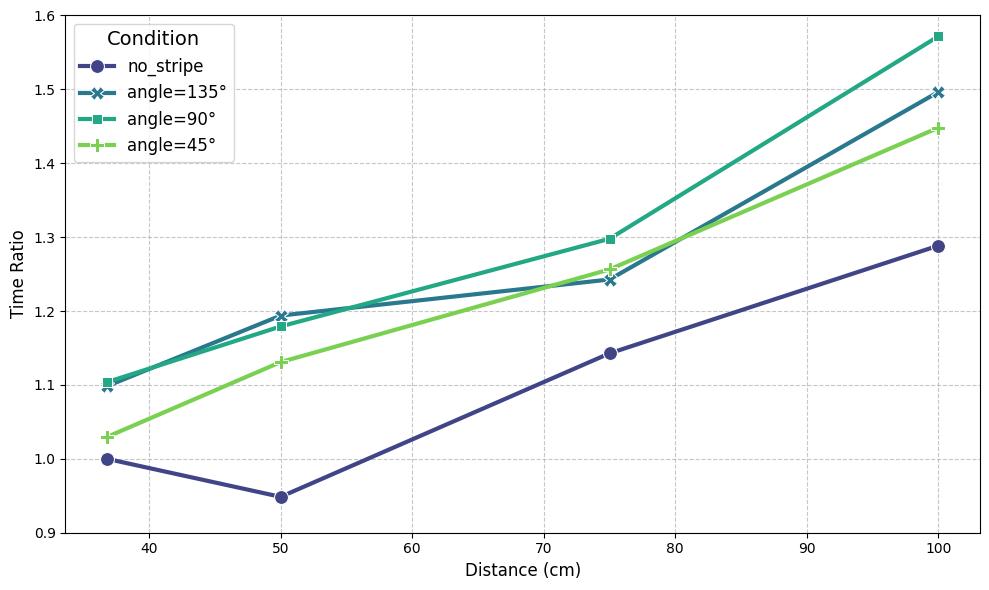

,distance,condition_label,time_ratio_mean,time_ratio_std,n
0,36.8,angle=135°,1.098364,0.390004,361
4,50.0,angle=135°,1.193884,0.516441,326
8,75.0,angle=135°,1.242705,0.505284,223
12,100.0,angle=135°,1.496522,0.950490,146
1,36.8,angle=45°,1.029623,0.321776,200
5,50.0,angle=45°,1.130955,0.409978,197
9,75.0,angle=45°,1.256343,0.555743,143
13,100.0,angle=45°,1.448148,0.706655,90
2,36.8,angle=90°,1.103781,0.426076,436
6,50.0,angle=90°,1.179166,0.489817,409


In [9]:
# データフォルダのパス
data_folder = 'edit_data'

# フォルダが存在しない場合のダミー処理（エラー回避用）
if not os.path.exists(data_folder):
    os.makedirs(data_folder, exist_ok=True)
    print(f"Warning: Folder '{data_folder}' not found. Created empty folder.")

# データフォルダ内のすべてのCSVファイルを取得
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

df = pd.DataFrame()

# 各CSVファイルを処理
for file_name in csv_files:
    file_path = os.path.join(data_folder, file_name)
    try:
        temp_df = pd.read_csv(file_path)
        df = pd.concat([df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

if df.empty:
    print("データが見つかりませんでした。")
else:
    # ---------------------------------------------------------
    # 前処理
    # ---------------------------------------------------------
    
    print("aa")
    
    # 正解のデータのみ使用
    df = df[df['TorF'] == 'T'].copy()
    
    df['scale'] = df['scale'].replace({'intended': '36cm'})
    
    # ベースライン条件の定義
    baseline_condition = (df["scale"] == "36cm") & (df["line_width"] == 0.0)

    # 被験者IDごとにベースライン時間の平均を算出 
    participant_baselines = df[baseline_condition].groupby('participant_id')['time'].mean()

    print("---")
    print("num_participants:", len(participant_baselines))

    # 元のデータフレームに個別のベースライン時間をマッピング
    df['individual_baseline'] = df['participant_id'].map(participant_baselines)

    print("---")
    print(f"Average Baseline Time：{participant_baselines.mean()}")

    # 各試行について「その人のベースラインに対する比率」を計算する
    # (1.0に近いほどベースラインと同等の速度、1.0より大きいほど時間がかかっている)
    df['time_ratio'] = df['time'] / df['individual_baseline']

    
    # -----------------------------
    # no_stripe 条件
    # -----------------------------
    no_stripe_df = df[
        (df['angle'] == 0.0) &
        (df['line_width'] == 0.0) &
        (df['period'] == 0.0)
    ].copy()

    no_stripe_df['distance'] = no_stripe_df['scale'].map(scale_to_distance_map)
    no_stripe_df = no_stripe_df.dropna(subset=['distance'])

    # 凡例用ラベル
    no_stripe_df['condition_label'] = 'no_stripe'
    
    # -----------------------------
    # stripe 条件
    # -----------------------------
    stripe_df = df[
        (df['angle'].isin([45.0, 90.0, 135.0])) &
        (df['line_width'].isin([1.0,2.0,3.0,4.0,5.0,6.0,7.0])) &
        (df['period'].isin([2.0,3.0,4.0,5.0,6.0,7.0,8.0]))
    ].copy()

    stripe_df['distance'] = stripe_df['scale'].map(scale_to_distance_map)
    stripe_df = stripe_df.dropna(subset=['distance'])

    # 凡例用ラベル（角度をそのまま使う）
    stripe_df['condition_label'] = 'angle=' + stripe_df['angle'].astype(int).astype(str) + '°'
    
    plot_df = pd.concat(
    [no_stripe_df, stripe_df],
    ignore_index=True
    )   
    
    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=plot_df,
        x='distance',
        y='time_ratio',
        hue='condition_label',
        style='condition_label',
        palette='viridis',
        linewidth=3.0,
        markers=True,
        markersize=10,
        dashes=False,
        errorbar=None,
    )

    plt.xlabel('Distance (cm)', fontsize=12)
    plt.ylabel('Time Ratio', fontsize=12)
    plt.ylim(0.90, 1.60)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.legend(title='Condition', fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # プロットされた値（Seabornと同一集約）をdfで取得
    # ---------------------------------------------------------
    plot_mean_df = (
        plot_df
        .groupby(['distance', 'condition_label'], as_index=False)
        .agg(
            time_ratio_mean=('time_ratio', 'mean'),
            time_ratio_std=('time_ratio', 'std'),
            n=('time_ratio', 'count')
        )
        .sort_values(['condition_label', 'distance'])
    )

    display(plot_mean_df)
